# STA 141B Final Project
Fall 2018

Xavier Hung

Weiyi Chen

## Problem: Is there a correlation between speeding and red light camera violations?
### Case study: Chicago

Many people are likely to speed up as they approach an intersection when the traffic light turns yellow.  It is dangerous and can sometimes lead to a fatal crash. 

This common occurrence brought us to analyze the association between red light violations and speeding. 

####  Data Extraction

We obtained our data from the City of Chicago. There are four CSV files: red light camera locations, red light camera violations, speed camera locations, and speed camera violations (details of these data can be found at https://data.cityofchicago.org/browse?q=red+light+camera&sortBy=relevance).

In [2]:
import os
import pandas as pd
import numpy as np
import math
from ast import literal_eval
from bokeh.plotting import figure, show, output_notebook
from bokeh.models.annotations import Title
from bokeh.tile_providers import CARTODBPOSITRON
# import numpy
#  from scipy.stats import linregress
from scipy.stats import spearmanr
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

redlight_loc = pd.read_csv('red-light-camera-locations.csv')
redlight_violations = pd.read_csv('red-light-camera-violations.csv')

speed_loc = pd.read_csv('speed-camera-locations.csv')
speed_violations = pd.read_csv('speed-camera-violations.csv')

#### check shape and missing values

In [3]:
redlight_loc.shape, redlight_violations.shape, speed_loc.shape, speed_violations.shape

((149, 8), (423260, 10), (161, 7), (165141, 9))

In [4]:
redlight_loc.isnull().sum(), redlight_violations.isnull().sum(), speed_loc.isnull().sum(), speed_violations.isnull().sum()

#the columns we will use have no missing value.

(INTERSECTION         0
 FIRST APPROACH       0
 SECOND APPROACH      2
 THIRD APPROACH     145
 GO LIVE DATE         0
 LATITUDE             0
 LONGITUDE            0
 LOCATION             0
 dtype: int64, INTERSECTION          0
 CAMERA ID           552
 ADDRESS               0
 VIOLATION DATE        0
 VIOLATIONS            0
 X COORDINATE      24895
 Y COORDINATE      24895
 LATITUDE          24895
 LONGITUDE         24895
 LOCATION          24895
 dtype: int64, ADDRESS             0
 FIRST APPROACH      2
 SECOND APPROACH    94
 GO-LIVE DATE        0
 LATITUDE            0
 LONGITUDE           0
 LOCATION            0
 dtype: int64, ADDRESS              0
 CAMERA ID            0
 VIOLATION DATE       0
 VIOLATIONS           0
 X COORDINATE      6374
 Y COORDINATE      6374
 LATITUDE          6374
 LONGITUDE         6374
 LOCATION          6374
 dtype: int64)

`speed_loc` and `redlight_loc` have columns, latitude and longitude. We use Mercator projection to convert latitude and longitude into coordinates, and plot the locations of red light cameras and speed cameras.

In [6]:
# plot red light cameras and speed cameras locations
speed_loc["COORDINATES"] = '('+ speed_loc["LATITUDE"].astype(str) +','+ speed_loc["LONGITUDE"].astype(str) + ')'
redlight_loc["COORDINATES"] = '('+ redlight_loc["LATITUDE"].astype(str) +','+ redlight_loc["LONGITUDE"].astype(str) + ')'

def merc(Coords):
    """Mercator projection: convert latitude and longitude into coordinates"""
    Coordinates = literal_eval(Coords)
    lat = Coordinates[0]
    lon = Coordinates[1]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

speed_loc['coords_x'] = speed_loc['COORDINATES'].apply(lambda x: merc(x)[0])
speed_loc['coords_y'] = speed_loc['COORDINATES'].apply(lambda x: merc(x)[1])

redlight_loc['coords_x'] = redlight_loc['COORDINATES'].apply(lambda x: merc(x)[0])
redlight_loc['coords_y'] = redlight_loc['COORDINATES'].apply(lambda x: merc(x)[1])


p = figure(x_range=(-9790000, -9735000), y_range=(5105000, 5165000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)
p.circle(x = redlight_loc['coords_x'], y = redlight_loc['coords_y'], legend = "Red Light Camera", fill_color="#FF0000")
p.circle(x = speed_loc['coords_x'], y = speed_loc['coords_y'], legend = "Speed Camera", alpha=0.4)
t = Title()
t.text = 'Locations of All Speed Cameras and Red Light Cameras'
p.title = t
p.legend.location = "top_right"
p.legend.click_policy="hide"
output_notebook()
show(p)

Loading BokehJS ...

In Chicago, 0.001 latitude is about 111.2 meters when longitude is constant. When latitude is constant, 0.001 longitude is about 82.69 meters. 
link: https://www.movable-type.co.uk/scripts/latlong.html

We subset the data by red light cameras and speed cameras that are near each other by 0.001 latitude and longitude. We created a dataframe called pairs that stores the matched locations of red light cameras with speed cameras.  We ended up with 18 locations that had red light cameras and speed cameras in close proximity.

In [26]:
# redlight_loc_copy is a subset of redlight_loc and contains the locations of red light cameras near speed cameras
# speed_loc_copy is a subset of speed_loc and contains the locations of speed cameras near red light cameras
redlight_loc_copy = pd.DataFrame(columns = redlight_loc.columns.values)
speed_loc_copy = pd.DataFrame(columns = speed_loc.columns.values)
pairs = pd.DataFrame(columns = ['speed', 'redlight'])

# find red light cameras near speed cameras
for i in range(0,speed_loc.shape[0]):
    for j in range(0,redlight_loc.shape[0]):
        if abs(speed_loc.iloc[i,4] - redlight_loc.iloc[j,5]) < 0.001 and abs(speed_loc.iloc[i,5] - redlight_loc.iloc[j,6]) < 0.001:
            redlight_loc_copy = redlight_loc_copy.append(redlight_loc.iloc[j], ignore_index = True)
            speed_loc_copy = speed_loc_copy.append(speed_loc.iloc[i], ignore_index = True)
            temp = pd.DataFrame({'speed': [speed_loc.iloc[i,0]], 'redlight': [redlight_loc.iloc[j,0]]})
            pairs = pairs.append(temp)
pairs = pairs.reset_index(drop = True)

In [8]:
# plot red light cameras near speed cameras
redlight_loc_copy["COORDINATES"] = '('+ redlight_loc_copy["LATITUDE"].astype(str) +','+ redlight_loc_copy["LONGITUDE"].astype(str) + ')'
speed_loc_copy["COORDINATES"] = '('+ speed_loc_copy["LATITUDE"].astype(str) +','+ speed_loc_copy["LONGITUDE"].astype(str) + ')'

speed_loc_copy['coords_x'] = speed_loc_copy['COORDINATES'].apply(lambda x: merc(x)[0])
speed_loc_copy['coords_y'] = speed_loc_copy['COORDINATES'].apply(lambda x: merc(x)[1])

redlight_loc_copy['coords_x'] = redlight_loc_copy['COORDINATES'].apply(lambda x: merc(x)[0])
redlight_loc_copy['coords_y'] = redlight_loc_copy['COORDINATES'].apply(lambda x: merc(x)[1])


p = figure(x_range=(-9780000, -9745000), y_range=(5120000, 5160000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)
p.circle(x = redlight_loc_copy['coords_x'], y = redlight_loc_copy['coords_y'], legend = "Red Light Camera", fill_color="#FF0000",size = 10)
p.circle(x = speed_loc_copy['coords_x'], y = speed_loc_copy['coords_y'], legend = "Speed Camera",alpha=0.5, size = 8)
t = Title()
t.text = 'Speed Cameras in Close Proximity to Red Light Cameras'
p.title = t
p.legend.location = "top_right"
p.legend.click_policy="hide"
output_notebook()
show(p)

Loading BokehJS ...

In [28]:
# change format of addresses in speed_loc_copy to match format of addresses in speed_violations
remove = ["(Speed", "Camera)", "Ave", "ST", "Rd", "St", "Blvd",'Dr']
for i in range(0, speed_loc_copy.shape[0]):
    speed_loc_copy.iloc[i,0] = " ".join([word for word in speed_loc_copy.iloc[i,0].split() if word not in remove])

for i in range(0, pairs.shape[0]):
    pairs.iloc[i,0] = " ".join([word for word in pairs.iloc[i,0].split() if word not in remove]).upper()
    pairs.iloc[i,1] = pairs.iloc[i,1].upper()
    
    
# subset speed violations where speed cameras are near red light cameras
speed_violations_copy = pd.DataFrame(columns = speed_violations.columns.values)    
for i in range(0, speed_loc_copy.shape[0]):
    address = speed_violations[speed_violations['ADDRESS'].str.contains(speed_loc_copy.iloc[i,0].upper())]
    speed_violations_copy = speed_violations_copy.append(address, ignore_index = True)
    if len(address.index) > 0:
        pairs.iloc[i,0] = address.iloc[0,0]

In [30]:
# subset red light violations where speed cameras are near red light cameras
# this will take a while
redlight_violations_copy = pd.DataFrame(columns = redlight_violations.columns.values)
for i in range (0, redlight_violations.shape[0]):
    for j in range(0, redlight_loc_copy.shape[0]):
        intersection1 = redlight_violations.iloc[i,0].replace(' AND ', '/').replace(' and ', '/').split('/')
        intersection2 = redlight_loc_copy.iloc[j,0].split('-')
        if len(intersection1) > 1 and len(intersection2) > 1:
            if intersection1[0] == intersection2[0].upper() or intersection1[0] == intersection2[1].upper():
                if intersection1[1] == intersection2[0].upper() or intersection1[1] == intersection2[1].upper():
                    redlight_violations_copy = redlight_violations_copy.append(redlight_violations.iloc[i], ignore_index = True)
                    pairs.iloc[j,1] = redlight_violations.iloc[i,0]

18 location pairs that had red light cameras and speed cameras in close proximity.

In [32]:
pairs.sort_values(['redlight'])

,speed,redlight
2,3217 W 55TH ST,55TH AND KEDZIE
3,3212 W 55TH ST,55TH AND KEDZIE
5,5532 S KEDZIE AVE,55TH AND KEDZIE
7,5428 S PULASKI,55TH and PULASKI
13,5433 S PULASKI,55TH and PULASKI
6,4123 N CENTRAL AVE,CENTRAL AND IRVING PARK
1,450 N COLUMBUS DR,COLUMBUS AND ILLINOIS
15,324 E ILLINOIS ST,COLUMBUS AND ILLINOIS
14,449 N COLUMBUS DR,COLUMBUS AND ILLINOIS
17,819 E 71ST ST,COTTAGE GROVE AND 71ST


We convert the daily violations to monthly violations, and plot speeding and red light camera violations over time at 10 different intersections, respectively.
For each intersection, we will compare the trend of speed violations with the red light camera violations, and calculate the Spearman’s correlation coefficient and the p-value to test for non-correlation.

The Spearman correlation coefficient and p-value for speed violations at 449 N COLUMBUS DR and red light violations at COLUMBUS AND ILLINOIS are 0.16296345325527606 and 2.780441920692923e-52, respectively.
The Spearman correlation coefficient and p-value for speed violations at 450 N COLUMBUS DR and red light violations at COLUMBUS AND ILLINOIS are 0.2643607622753515 and 2.7954699071506953e-134, respectively.
The Spearman correlation coefficient and p-value for speed violations at 324 E ILLINOIS ST and red light violations at COLUMBUS AND ILLINOIS are -0.07541332152958609 and 0.0011137050274879702, respectively.


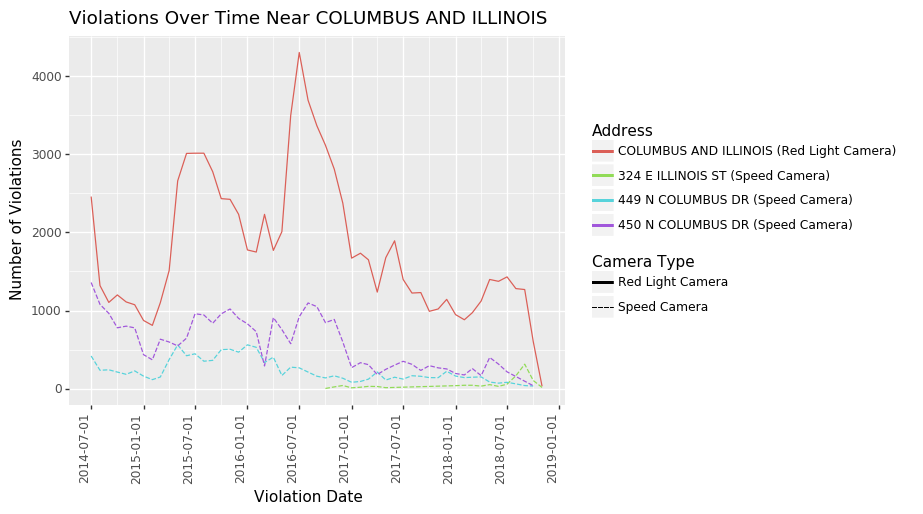

<ggplot: (-9223371891240897476)>
The Spearman correlation coefficient and p-value for speed violations at 5030 S PULASKI and red light violations at PULASKI AND ARCHER are 0.0858098835074142 and 8.32305340821259e-06, respectively.
The Spearman correlation coefficient and p-value for speed violations at 4929 S PULASKI and red light violations at PULASKI AND ARCHER are 0.08055678492137777 and 3.1888954495604886e-05, respectively.


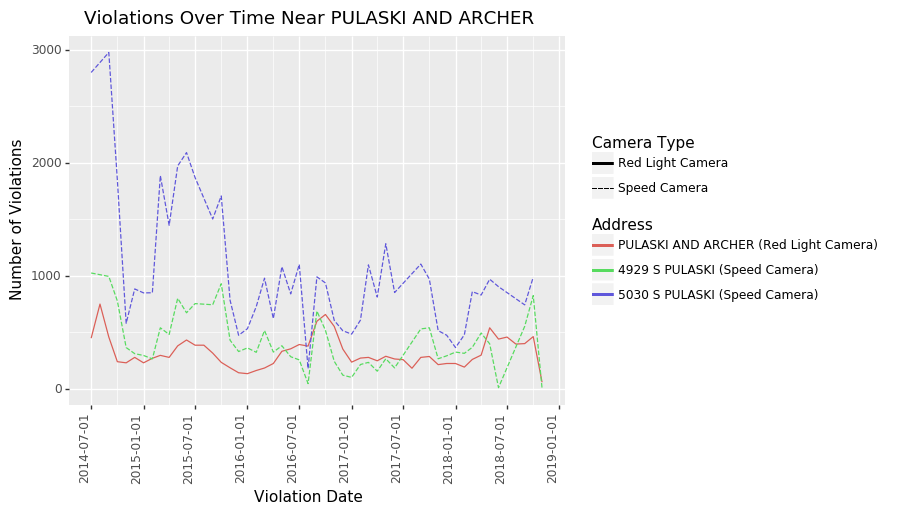

<ggplot: (145611014141)>
The Spearman correlation coefficient and p-value for speed violations at 7833 S PULASKI and red light violations at PULASKI AND 79TH are 0.04217155944082334 and 0.030951470650184894, respectively.
The Spearman correlation coefficient and p-value for speed violations at 7826 S PULASKI and red light violations at PULASKI AND 79TH are 0.014135354613446081 and 0.4688652652608186, respectively.


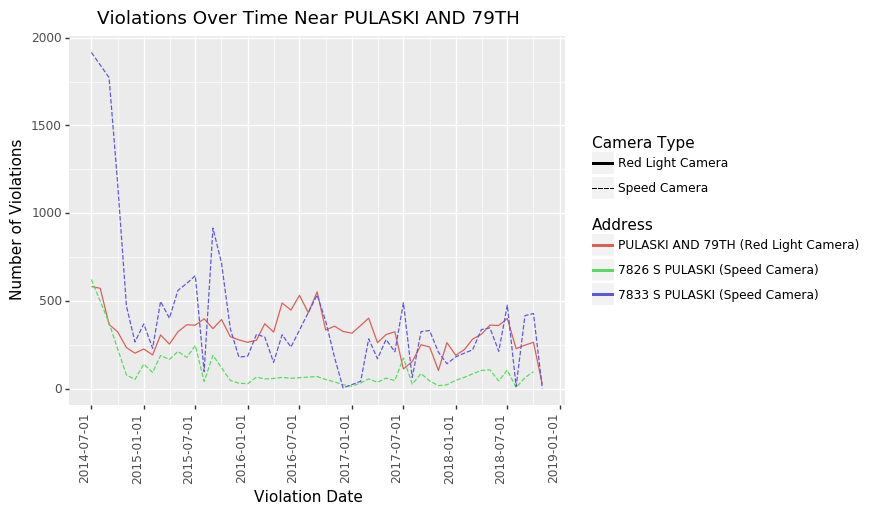

<ggplot: (-9223371891243753633)>
The Spearman correlation coefficient and p-value for speed violations at 5532 S KEDZIE AVE and red light violations at 55TH AND KEDZIE are 0.019641669561346203 and 0.3038798620398834, respectively.
The Spearman correlation coefficient and p-value for speed violations at 3212 W 55TH ST and red light violations at 55TH AND KEDZIE are -0.042898154058709455 and 0.06566213991596444, respectively.
The Spearman correlation coefficient and p-value for speed violations at 3217 W 55TH ST and red light violations at 55TH AND KEDZIE are 0.019253443838843958 and 0.4503866399393628, respectively.


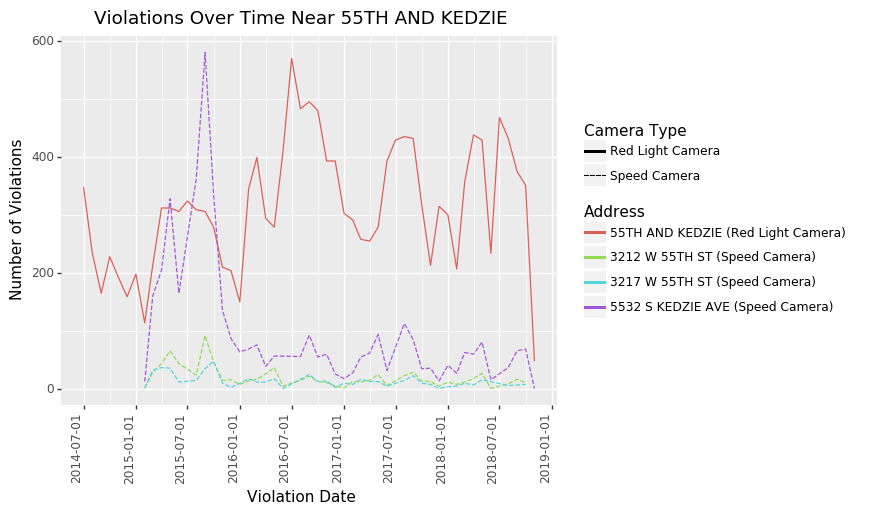

<ggplot: (-9223371891240911935)>
The Spearman correlation coefficient and p-value for speed violations at 819 E 71ST ST and red light violations at COTTAGE GROVE AND 71ST are -0.2981443785319082 and 0.012181737341665288, respectively.
The Spearman correlation coefficient and p-value for speed violations at 7122 S SOUTH CHICAGO AVE and red light violations at COTTAGE GROVE AND 71ST are -0.06509088557747152 and 0.5979424534067732, respectively.


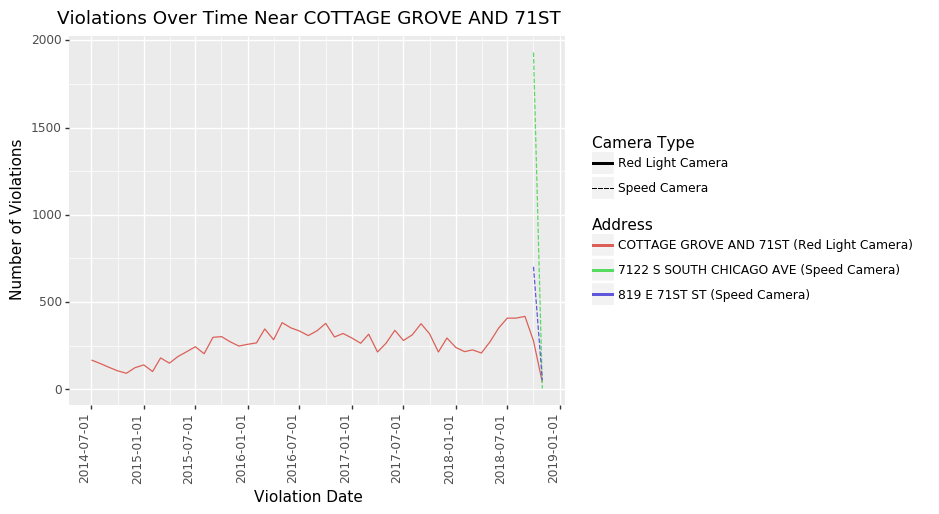

<ggplot: (-9223371891244077431)>
The Spearman correlation coefficient and p-value for speed violations at 5433 S PULASKI and red light violations at 55TH and PULASKI are 0.051366666490227586 and 0.013029076620337369, respectively.
The Spearman correlation coefficient and p-value for speed violations at 5428 S PULASKI and red light violations at 55TH and PULASKI are 0.12640609007441064 and 1.19662717128761e-09, respectively.


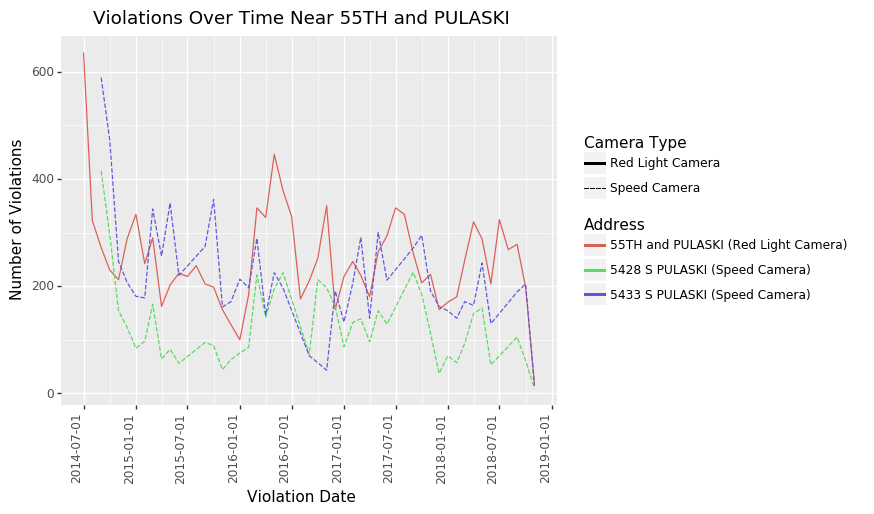

<ggplot: (145610693317)>
The Spearman correlation coefficient and p-value for speed violations at 3534 N WESTERN and red light violations at WESTERN AND ADDISON are 0.08296830544042871 and 0.01019696491485027, respectively.


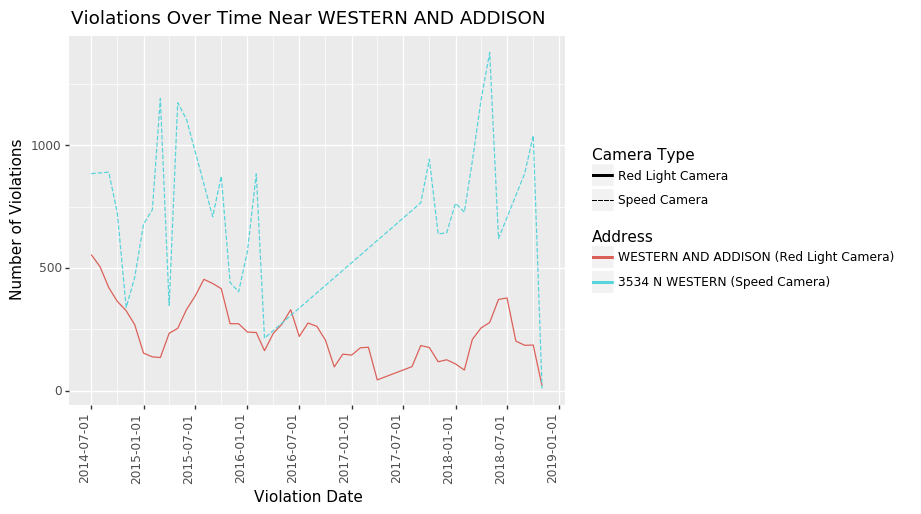

<ggplot: (145611035000)>
The Spearman correlation coefficient and p-value for speed violations at 2335 W CERMAK RD and red light violations at WESTERN AND CERMAK are 0.012647836650445315 and 0.6934076333012771, respectively.


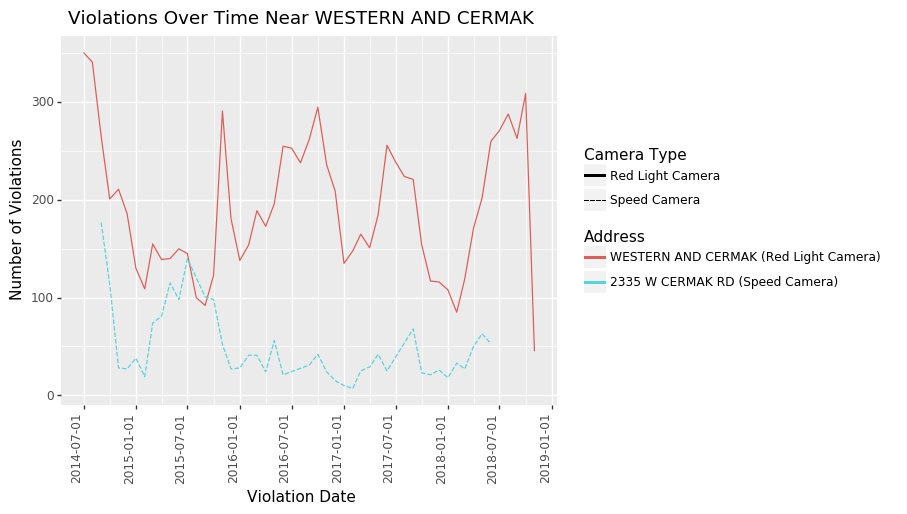

<ggplot: (-9223371891243495855)>
The Spearman correlation coefficient and p-value for speed violations at 732 N PULASKI RD and red light violations at PULASKI AND CHICAGO are -0.03054809323934059 and 0.2745974660494698, respectively.


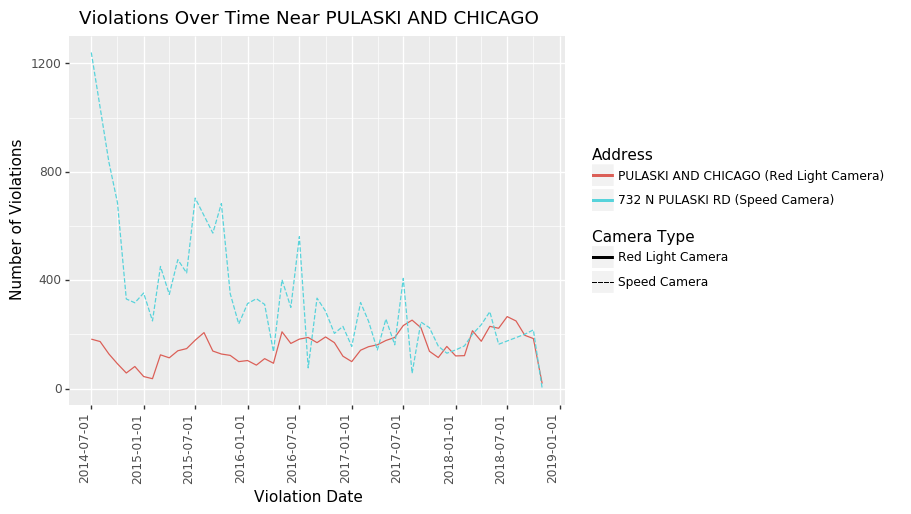

<ggplot: (145611229693)>
The Spearman correlation coefficient and p-value for speed violations at 4123 N CENTRAL AVE and red light violations at CENTRAL AND IRVING PARK are -0.026114602543561617 and 0.1987851408479989, respectively.


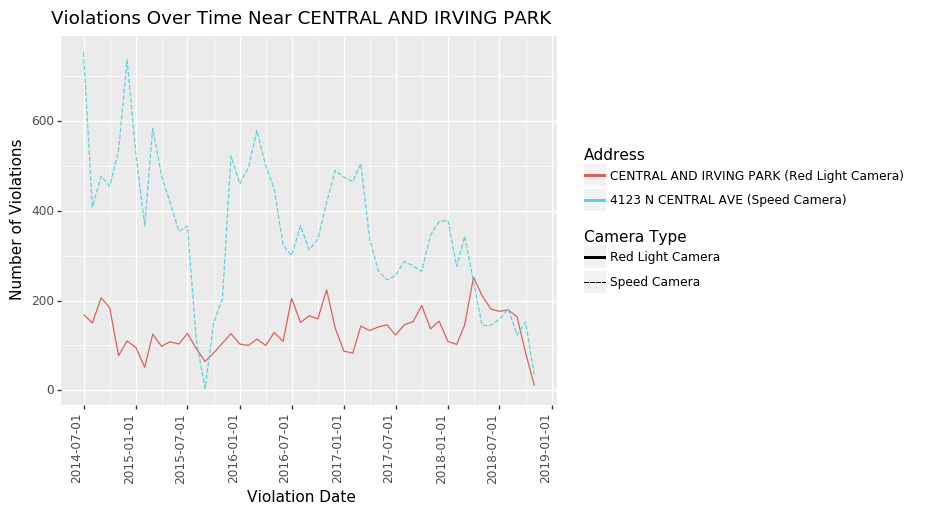

<ggplot: (-9223371891244093415)>


In [35]:
redlight = redlight_violations_copy.groupby('INTERSECTION')['VIOLATIONS'].sum().sort_values(ascending = False)

# output in order of most red light violations to least red light violations

for i in range(0, len(redlight)):
    rlc_violation_intersection = redlight_violations_copy.loc[redlight_violations_copy['INTERSECTION'].str.contains(redlight.axes[0][i])].reset_index(drop = True)

    rlc_speed = pd.DataFrame()
    temp = pairs.loc[pairs['redlight'] == rlc_violation_intersection.iloc[0,0]].reset_index(drop = True).iloc[:, 0].tolist()
    for j in range(0, len(temp)):
        rlc_speed = rlc_speed.append(speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(temp[j])].reset_index(drop = True))

    temp1 = rlc_speed
    temp1['VIOLATION DATE'] = pd.to_datetime(temp1['VIOLATION DATE'])
    temp2 = rlc_violation_intersection
    temp2['VIOLATION DATE'] = pd.to_datetime(temp2['VIOLATION DATE'])
    
    for k in range(0, len(temp1['ADDRESS'].value_counts())):
        temp = temp1.loc[temp1['ADDRESS'] == temp1['ADDRESS'].value_counts().index[k]]
        x1 = pd.DataFrame()
        x2 = pd.DataFrame()
        for l in range(0, len(temp)):
            for m in range(0, len(temp2)):
                if(temp['VIOLATION DATE'][l] == temp2['VIOLATION DATE'][m]):
                    x1 = x1.append(temp.iloc[l])
                    x2 = x2.append(temp2.iloc[m])
        #print('The Pearson correlation coefficient for speed violations at ', temp.iloc[0,0], ' and red light violations at ', x2.iloc[0,2], ' is ', numpy.corrcoef(x1['VIOLATIONS'], x2['VIOLATIONS'])[0,1], '.', sep = '')
        print('The Spearman correlation coefficient and p-value for speed violations at ', temp.iloc[0,0], ' and red light violations at ', x2.iloc[0,2], ' are ', spearmanr(x1['VIOLATIONS'], x2['VIOLATIONS'])[0], ' and ', spearmanr(x1['VIOLATIONS'], x2['VIOLATIONS'])[1], ', respectively.', sep = '')
        #print('R-squared for speed violations at ', temp.iloc[0,0], ' and red light violations at ', x2.iloc[0,2], ' is ', linregress(x1['VIOLATIONS'], x2['VIOLATIONS'])[2] ** 2, '.', sep = '')
    
    rlc_speed['date'] = pd.to_datetime(rlc_speed['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
    rlc_speed['date'] = pd.to_datetime(rlc_speed['date'])
    temp = rlc_speed.groupby(['ADDRESS', 'date'])['VIOLATIONS'].sum()
    plotdata_speed = pd.DataFrame({'ADDRESS': temp.index.get_level_values('ADDRESS'), 'date': temp.index.get_level_values('date'),'count': temp.values})
    plotdata_speed['camera_type'] = 'Speed Camera'

    rlc_violation_intersection['date'] = pd.to_datetime(rlc_violation_intersection['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
    rlc_violation_intersection['date'] = pd.to_datetime(rlc_violation_intersection['date'])
    temp = rlc_violation_intersection.groupby('date')['VIOLATIONS'].sum()
    plotdata_redlight = pd.DataFrame({'date': temp.index.get_level_values('date'), 'count': temp.values,'ADDRESS': rlc_violation_intersection.iloc[0,0]})
    plotdata_redlight['camera_type'] = 'Red Light Camera'

    plotdata_speed = plotdata_speed.loc[plotdata_speed['count'] != 0]
    plotdata_redlight = plotdata_redlight.loc[plotdata_redlight['count'] != 0]

    plotdata_speed['ADDRESS'] += ' (Speed Camera)'
    plotdata_redlight['ADDRESS'] += ' (Red Light Camera)'

    print(ggplot(aes(x = 'date', y = 'count', linetype = 'camera_type',color = 'ADDRESS'), data = plotdata_redlight)
      + geom_line()
      + geom_line(aes(x = 'date', y = 'count', linetype = 'camera_type',color = 'ADDRESS'), data = plotdata_speed)
      + labs(x = 'Violation Date', y = 'Number of Violations',color = 'Address',linetype='Camera Type')
      + theme(axis_text_x  = element_text(angle = 90, hjust = 1))
      + ggtitle('Violations Over Time Near ' + rlc_violation_intersection.iloc[0,0]))